## Importing libraries 

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import eda_helper_functions
from sklearn.ensemble import IsolationForest



## Read the training data 

In [10]:
file_path= r"E:\flight price prediction using sagemaker\dataset\train.csv"
train = pd.read_csv(file_path)
train.head()

,airline,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,date_of_Journey,price
0,Jet Airways,Delhi,Cochin,14:35:00,12:35:00,1320,2.0,In-flight meal not included,2019-06-15,10919
1,Spicejet,Banglore,New Delhi,10:20:00,18:15:00,475,1.0,No Info,2019-03-09,7294
2,Indigo,Banglore,New Delhi,20:00:00,22:55:00,175,0.0,No Info,2019-03-03,6860
3,Multiple Carriers,Delhi,Cochin,04:55:00,19:15:00,860,1.0,No Info,2019-05-21,7575
4,Vistara,Banglore,Delhi,19:30:00,22:15:00,165,0.0,No Info,2019-04-06,5613


In [11]:
train.dtypes

airline             object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
date_of_Journey     object
price                int64
dtype: object

In [15]:
train = train.assign(**{
	col: pd.to_datetime(train.loc[:, col], dayfirst=True, format="mixed")
	for col in ["date_of_Journey", "dep_time", "arrival_time"]
})

train.dtypes

airline                    object
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
date_of_Journey    datetime64[ns]
price                       int64
dtype: object

In [16]:
train

,airline,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,date_of_Journey,price
0,Jet Airways,Delhi,Cochin,2024-05-28 14:35:00,2024-05-28 12:35:00,1320,2.0,In-flight meal not included,2019-06-15,10919
1,Spicejet,Banglore,New Delhi,2024-05-28 10:20:00,2024-05-28 18:15:00,475,1.0,No Info,2019-03-09,7294
2,Indigo,Banglore,New Delhi,2024-05-28 20:00:00,2024-05-28 22:55:00,175,0.0,No Info,2019-03-03,6860
3,Multiple Carriers,Delhi,Cochin,2024-05-28 04:55:00,2024-05-28 19:15:00,860,1.0,No Info,2019-05-21,7575
4,Vistara,Banglore,Delhi,2024-05-28 19:30:00,2024-05-28 22:15:00,165,0.0,No Info,2019-04-06,5613
...,...,...,...,...,...,...,...,...,...,...
635,Multiple Carriers,Delhi,Cochin,2024-05-28 14:00:00,2024-05-28 01:30:00,690,1.0,No Info,2019-05-15,13727
636,Indigo,Mumbai,Hyderabad,2024-05-28 12:00:00,2024-05-28 13:30:00,90,0.0,No Info,2019-05-09,4392
637,Indigo,Banglore,Delhi,2024-05-28 23:30:00,2024-05-28 02:20:00,170,0.0,No Info,2019-04-27,3943
638,Jet Airways,Kolkata,Banglore,2024-05-28 21:10:00,2024-05-28 08:15:00,665,1.0,No Info,2019-05-01,14781


## 3. High-level Summary of Data

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   source           640 non-null    object        
 2   destination      640 non-null    object        
 3   dep_time         640 non-null    datetime64[ns]
 4   arrival_time     640 non-null    datetime64[ns]
 5   duration         640 non-null    int64         
 6   total_stops      640 non-null    float64       
 7   additional_info  640 non-null    object        
 8   date_of_Journey  640 non-null    datetime64[ns]
 9   price            640 non-null    int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 50.1+ KB


In [19]:
train.describe(include='number')

,duration,total_stops,price
count,640.000000,640.000000,640.000000
mean,620.515625,0.825000,9006.150000
std,477.581249,0.645679,4141.301489
min,75.000000,0.000000,1965.000000
25%,175.000000,0.000000,5678.000000
50%,515.000000,1.000000,8085.000000
75%,865.000000,1.000000,12275.750000
max,2300.000000,3.000000,26890.000000


In [22]:
(
	train
	.assign(total_stops=train["total_stops"].astype(object))
	.describe(include="O")
)

,airline,source,destination,total_stops,additional_info
count,640,640,640,640.0,640
unique,8,5,6,4.0,5
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,227,278,278,357.0,499


## 4. High-level analysis of Missing Values

In [23]:

eda_helper_functions.missing_info(train)

,count,percentage
variable,,


## 5. High-level analysis of Outliers

In [27]:
forest = IsolationForest(n_estimators=10, random_state=42)

In [28]:
(
	train
	.assign(outlier=forest.fit_predict(
		train
		.drop(columns="price")
		.select_dtypes(include="number")
	))
	.query("outlier == -1")
	#.duration
	#.describe()
)

,airline,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,date_of_Journey,price,outlier
0,Jet Airways,Delhi,Cochin,2024-05-28 14:35:00,2024-05-28 12:35:00,1320,2.0,In-flight meal not included,2019-06-15,10919,-1
2,Indigo,Banglore,New Delhi,2024-05-28 20:00:00,2024-05-28 22:55:00,175,0.0,No Info,2019-03-03,6860,-1
5,Vistara,Delhi,Cochin,2024-05-28 06:00:00,2024-05-28 09:10:00,190,0.0,No Info,2019-06-06,6216,-1
8,Jet Airways,Delhi,Cochin,2024-05-28 20:55:00,2024-05-28 19:00:00,1325,1.0,In-flight meal not included,2019-05-09,12373,-1
9,Air India,Banglore,New Delhi,2024-05-28 08:50:00,2024-05-28 16:20:00,1890,2.0,No Info,2019-03-12,12778,-1
...,...,...,...,...,...,...,...,...,...,...,...
622,Air India,Delhi,Cochin,2024-05-28 22:00:00,2024-05-28 19:15:00,1275,2.0,No Info,2019-06-12,10231,-1
623,Air India,Delhi,Cochin,2024-05-28 14:10:00,2024-05-28 17:10:00,180,0.0,No Info,2019-06-01,6934,-1
626,Spicejet,Mumbai,Hyderabad,2024-05-28 05:45:00,2024-05-28 07:15:00,90,0.0,No Info,2019-06-27,2017,-1
627,Vistara,Delhi,Cochin,2024-05-28 06:00:00,2024-05-28 09:10:00,190,0.0,No Info,2019-04-24,6216,-1


## 6. Pair Plots

c:\Users\Hp\.conda\envs\ml_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Hp\.conda\envs\ml_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Hp\.conda\envs\ml_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Hp\.conda\envs\ml_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


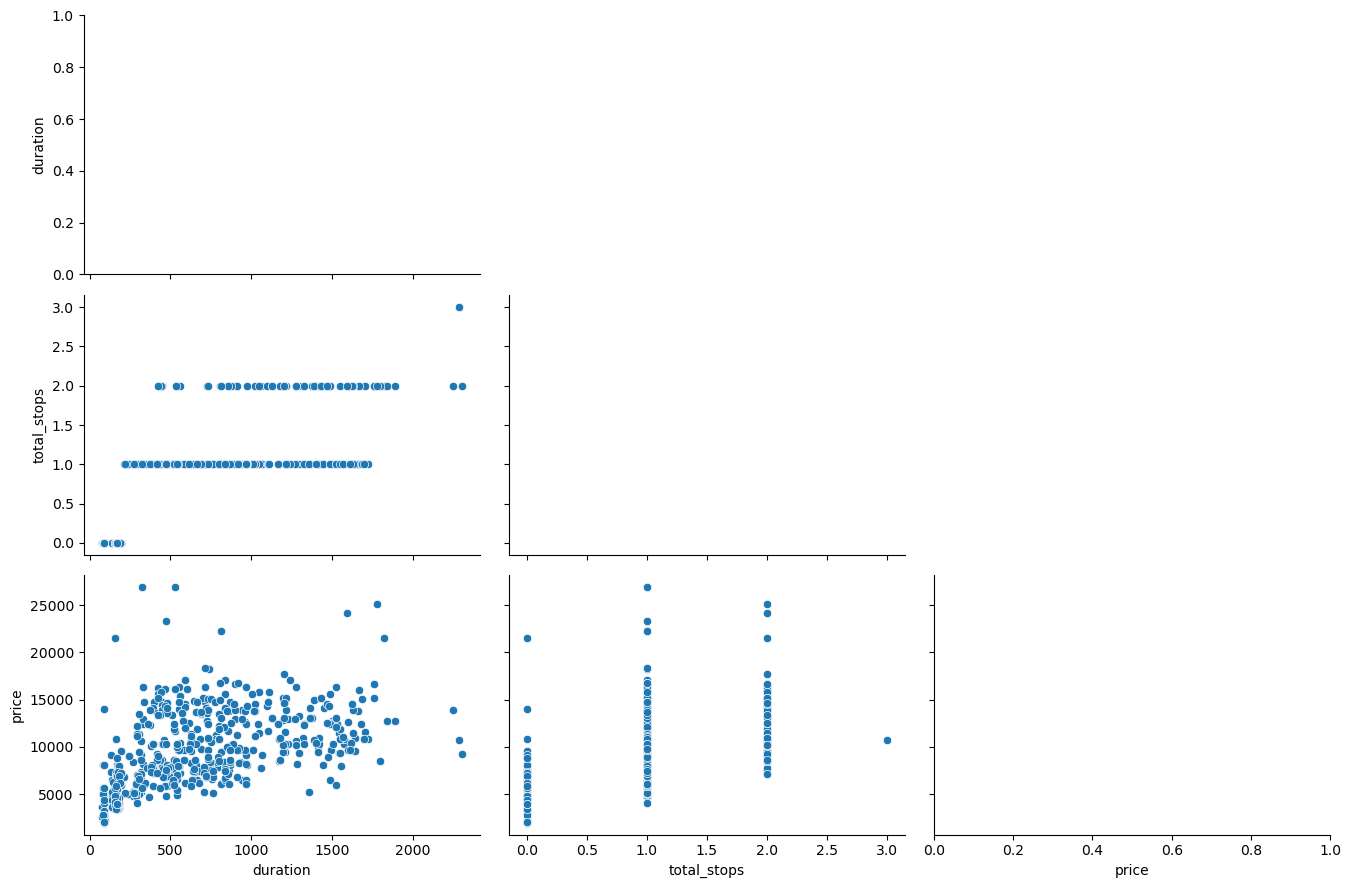

In [29]:
eda_helper_functions.pair_plots(train)

## 7. Correlation Analysis

c:\Users\Hp\.conda\envs\ml_env\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


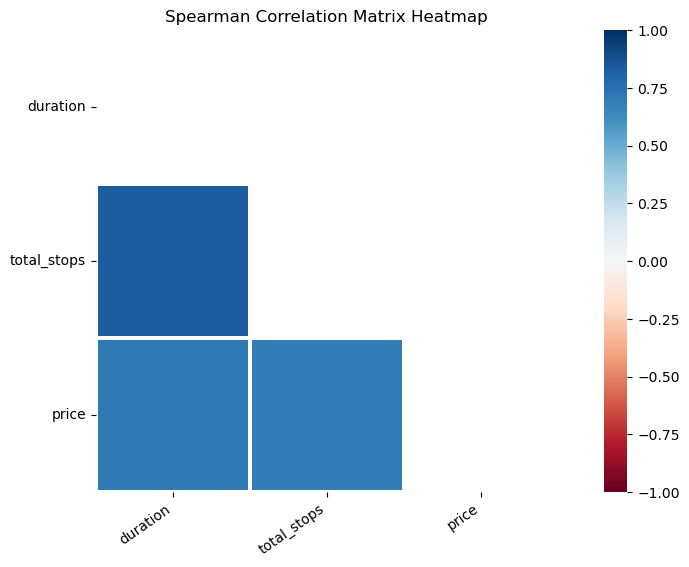

In [31]:
eda_helper_functions.correlation_heatmap(train)

c:\Users\Hp\.conda\envs\ml_env\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


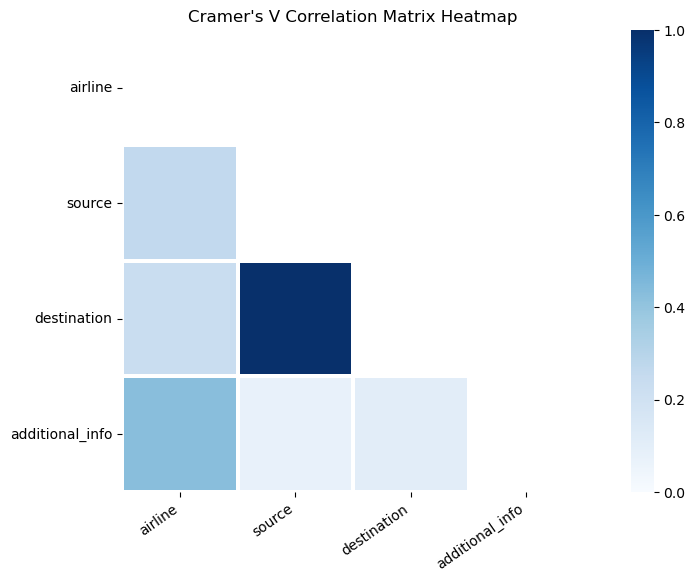

In [32]:
eda_helper_functions.cramersV_heatmap(train)

In [34]:
train.corr(method="spearman",numeric_only=True)

,duration,total_stops,price
duration,1.000000,0.828566,0.717003
total_stops,0.828566,1.000000,0.697264
price,0.717003,0.697264,1.000000


c:\Users\Hp\.conda\envs\ml_env\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


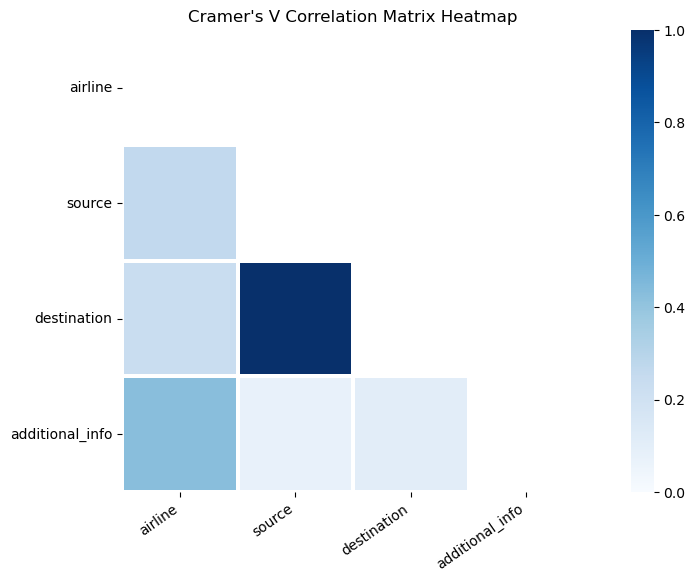

In [35]:
eda_helper_functions.cramersV_heatmap(train)